In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import h5py
import argparse
import glob
import matplotlib as mpl
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
import tqdm 


from matplotlib.axes import Axes


In [2]:
# Helper functions
# Helper functions relating io_group/io_channel/tile/chip/channel
def io_channel_to_tile(io_channel):
    return int(np.floor((io_channel-1-((io_channel-1)%4))/4+1))

def unique_channel_id(d):
    return ((d['io_group'].astype(int)*1000+d['io_channel'].astype(int))*1000
            + d['chip_id'].astype(int))*100 + d['channel_id'].astype(int)

def unique_to_channel_id(unique):
    return unique % 100

def unique_to_chip_id(unique):
    return (unique // 100) % 1000

def unique_to_io_channel(unique):
    return (unique//(100*1000)) % 1000

def unique_to_tiles(unique):
    return ((unique_to_io_channel(unique)-1) // 4) + 1

def unique_to_io_group(unique):
    return (unique // (100*1000*1000)) % 1000

# Geometry defaults
def _default_pxy():
    return (0., 0.)

def _rotate_pixel(pixel_pos, tile_orientation):
    return pixel_pos[0]*tile_orientation[2], pixel_pos[1]*tile_orientation[1]

# Rasterize plots 
_old_axes_init = Axes.__init__
def _new_axes_init(self, *a, **kw):
    _old_axes_init(self, *a, **kw)
    # https://matplotlib.org/stable/gallery/misc/zorder_demo.html
    # 3 => leave text and legends vectorized
    self.set_rasterization_zorder(3)
def rasterize_plots():
    Axes.__init__ = _new_axes_init
def vectorize_plots():
    Axes.__init__ = _old_axes_init
rasterize_plots()


def get_files_in_dataset(datadirs, date):
    """
    Get list of files in the dataset for a given date.
    """
    h5_files = []
    for dir in datadirs:
        h5_files_new = glob.glob(f'{dir}/*packet*{date}*5')
        h5_files += h5_files_new
    print("Number of H5 Files:", len(h5_files), "in dataset from directory:", datadirs)
    return h5_files


def make_single_dataset_plots(channel_stats_dict, dataset_name, date):
    """
    Make plots for a single dataset.
    """

    # Set up output PDF
    dataset_output_pdf = 'plots/'+dataset_name+'_'+date+'2x2_WCC_analysis_summary.pdf'
    plt.rcParams["figure.figsize"] = (10,8)
    with PdfPages(dataset_output_pdf) as output_pdf:

        # Get mean and std datawords for each channel
        for stats in channel_stats_dict.values():
            mean_datawords = np.array(stats['mean'])
            std_datawords = np.array(stats['std'])

        dataword_bins = np.linspace(0, 255, 256)
        # Plot histogram of mean datawords
        fig = plt.figure(figsize=(10,10))
        fig.tight_layout()
        mean_dw_counts, mean_dw_bins = np.histogram(mean_datawords, bins=dataword_bins)
        plt.hist(mean_dw_bins[:-1], bins=dataword_bins, weights=mean_dw_counts, color='blue', alpha=0.7)
        plt.title(f"Mean Datawords for {dataset_name} Dataset on {date}")
        plt.xlabel('Mean Dataword Value')
        plt.ylabel('Fraction of Channels')
        #plt.xlim(0, 255)
        #plt.ylim(0,1.1)
        output_pdf.savefig()
        plt.close()

        # Plot histogram of std datawords
        fig = plt.figure(figsize=(10,10))
        fig.tight_layout()
        std_dw_counts, std_dw_bins = np.histogram(std_datawords)
        plt.hist(std_dw_bins[:-1], bins=std_dw_bins, weights=std_dw_counts, color='red', alpha=0.7)
        plt.title(f"Standard Deviation of Datawords for {dataset_name} Dataset on {date}")
        plt.xlabel('Standard Deviation of Dataword Value')
        plt.ylabel('Fraction of Channels')
        plt.hist()
        output_pdf.savefig()
        plt.close()

    return 0

# Function to update running statistics (mean and variance)
def update_channel_dict_stats(stats, values):
    values = np.array(values, dtype=np.float64)  # Ensure values is a numpy array
    stats['count'] += len(values)
    if len(values) == 0:
        return stats
    # Update sum and sum of squares
    #print("Values: ", values)
    #sum_of_values = np.sum(values)
    #squared_values = np.square(values)
    #print("Squared values: ", squared_values)
    #sum_of_squares = np.sum(squared_values)
    #print("Sum of values: ", sum_of_values)
    #stats['sum'] += sum_of_values
    #print("Sum_of_squares: ", sum_of_squares)
    #stats['sum_of_squares'] += sum_of_squares
    stats['sum'] += np.sum(values)
    stats['sum_of_squares'] += np.sum(np.square(values))

    return stats

def make_channel_stats_dict(h5_files, dataset_name, max_entries=-1):

    channel_running_stats_dict = defaultdict(lambda: {'sum': 0.0, 'sum_of_squares': 0.0, 'count': 0.0})

    # Loop over files in dataset
    number_of_files = len(h5_files)
    for i in range(number_of_files):

        print("File number:", i, "in Set", dataset_name, "out of", number_of_files)
        file = h5_files[i]
        f = h5py.File(file,'r')
        packets = f['packets']
        data_packet_mask = packets[:]['packet_type'] == 0  # Only consider data packets
        valid_parity_mask = packets[:]['valid_parity'] == 1  # Only consider packets with valid parity
        # Combine masks to filter packets
        valid_data_mask = np.logical_and(data_packet_mask, valid_parity_mask)
        adc_datawords = f['packets']['dataword'][valid_data_mask][:max_entries]
        unique_ids = unique_channel_id(f['packets'][valid_data_mask][:max_entries])
        unique_id_set = np.unique(unique_ids)

        # Update channel statistics
        for uid in tqdm.tqdm(unique_id_set[:25000], desc="Looping over active channels ..."):
            stats = channel_running_stats_dict[uid]
            channel_mask = unique_ids == uid
            channel_datawords = adc_datawords[channel_mask]
            stats = update_channel_dict_stats(stats, channel_datawords)
            channel_running_stats_dict[uid] = stats

    # Finalize channel statistics across all files

    channel_final_stats_dict = {}
    i=0
    for uid, stats in channel_running_stats_dict.items():
        i += 1
        if stats['count'] > 0:
            mean = stats['sum'] / stats['count']
            variance = (stats['sum_of_squares'] / stats['count']) - (mean ** 2)
            # Debugging output
            if i % 100 == 0:
                print(f"Channel {uid}: Mean = {mean}, Variance = {variance}, Squared mean = {mean ** 2}, Avg Sum of squares = {stats['sum_of_squares']/stats['count']}")
            std = np.sqrt(variance)
            channel_final_stats_dict[uid] = {
                'mean': np.round(mean,2),
                'std': np.round(std,2), 
                'count': stats['count']
            }
        else:
            channel_final_stats_dict[uid] = {
                'mean': 0.0,
                'std': 0.0, 
                'count': 0.0
            }
    del channel_running_stats_dict  # Clean up memory

    return channel_final_stats_dict

In [3]:
#datadirs1 = ['/global/cfs/cdirs/dune/www/data/2x2/CRS.run2/WarmComissioning/NominalPedestal_v2/'] # placeholder
datadirs1 = ['/global/cfs/cdirs/dune/www/data/2x2/nearline/packet/commission/June2024/noise_assessments_06_05/']
datadirs2 = None  # Placeholder for second dataset directories
#dataset1_name = '13_08_2025_Nominal_Test_ONE_FILE'  # Placeholder for dataset 1 name
dataset1_name = '06_05_2024_Pedestal_Test_One_File'
dataset2_name = 'Dataset2'  # Placeholder for dataset 2 name
date = '2024_06_05'  # Placeholder for date

# Get list of files in dataset 1
h5_files_set1 = get_files_in_dataset(datadirs1, date)[3:4]
print("File:", h5_files_set1)
dataset1_stats_dict = make_channel_stats_dict(h5_files_set1, dataset1_name, max_entries=-1)

## Check if there is a second dataset to compare against
#compare_two_datasets = False
#if datadirs2 is not None:
#    compare_two_datasets = True#
## Get list of files in dataset 2 if it exists
#if compare_two_datasets == True:
#    h5_files_set2 = get_files_in_dataset(datadirs2, date)
#    dataset2_stats_dict = make_channel_stats_dict(h5_files_set2, dataset2_name, max_entries=-1)
#    make_single_dataset_plots(dataset2_stats_dict, dataset2_name, date)

Number of H5 Files: 45 in dataset from directory: ['/global/cfs/cdirs/dune/www/data/2x2/nearline/packet/commission/June2024/noise_assessments_06_05/']
File: ['/global/cfs/cdirs/dune/www/data/2x2/nearline/packet/commission/June2024/noise_assessments_06_05/packet-pedestal-pumping-2024_06_05_16_41_42_CDT.h5']
File number: 0 in Set 06_05_2024_Pedestal_Test_One_File out of 1


Looping over active channels ...: 100%|██████████████████████████████████████████████████████████████████████| 25000/25000 [00:52<00:00, 480.43it/s]


Channel 100101301: Mean = 26.545454545454547, Variance = 0.7933884297519853, Squared mean = 704.6611570247935, Avg Sum of squares = 705.4545454545455
Channel 100101503: Mean = 28.90909090909091, Variance = 0.9917355371900385, Squared mean = 835.7355371900827, Avg Sum of squares = 836.7272727272727
Channel 100101705: Mean = 25.25, Variance = 0.6875, Squared mean = 637.5625, Avg Sum of squares = 638.25
Channel 100101911: Mean = 25.75, Variance = 0.6875, Squared mean = 663.0625, Avg Sum of squares = 663.75
Channel 100102113: Mean = 28.666666666666668, Variance = 0.8888888888888005, Squared mean = 821.7777777777778, Avg Sum of squares = 822.6666666666666
Channel 100102315: Mean = 29.272727272727273, Variance = 0.3801652892561833, Squared mean = 856.8925619834711, Avg Sum of squares = 857.2727272727273
Channel 100102517: Mean = 30.0, Variance = 0.7272727272727479, Squared mean = 900.0, Avg Sum of squares = 900.7272727272727
Channel 100102719: Mean = 26.75, Variance = 0.8541666666666288, Squ

Count datawords: [12. 12. 12. ... 12. 12. 12.]


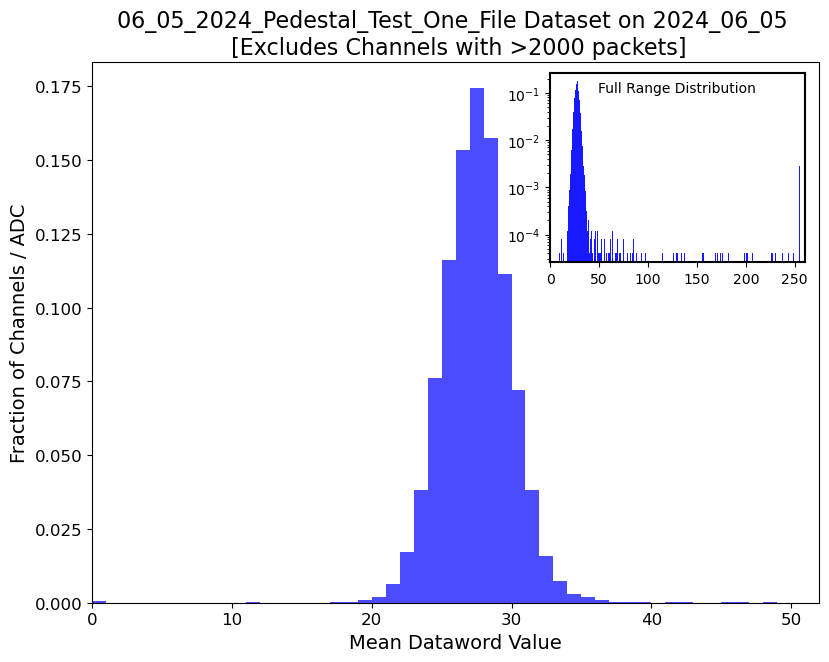

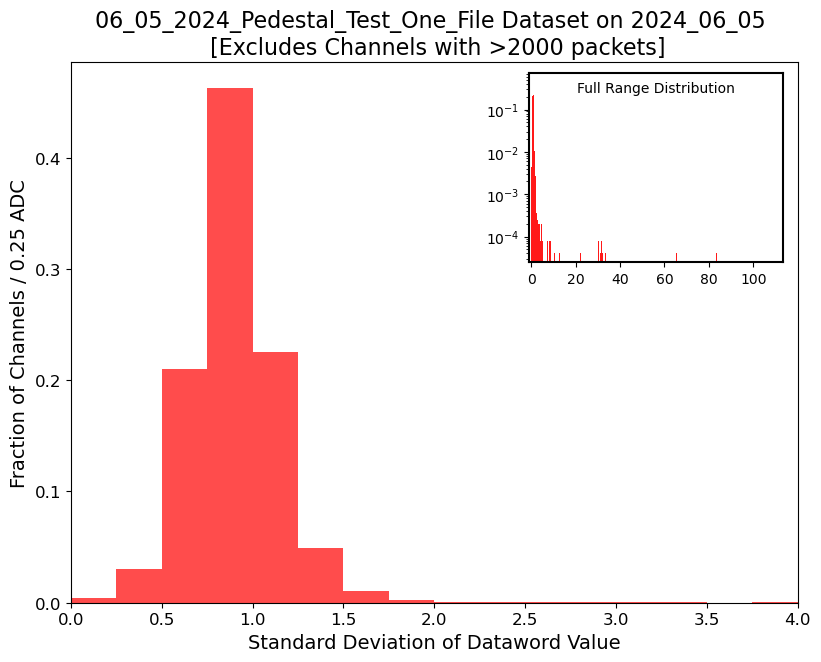

20


ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x600 with 1 Axes>

In [ ]:
dataset_name = dataset1_name
mean_datawords = []
std_datawords = []
count_datawords = []
for uid, stats in dataset1_stats_dict.items():
    chip_id = unique_to_chip_id(uid)
    # Exclude invalid chip ids
    if chip_id not in range(11, 111):
        continue
    # Also exclude channels with > 2000 valid packets (expect 1000)
    elif stats['count'] > 2000:
        continue
    else:
        mean_datawords.append(stats['mean'])
        std_datawords.append(stats['std'])
        count_datawords.append(stats['count'])
mean_datawords = np.array(mean_datawords)
std_datawords = np.array(std_datawords)
count_datawords = np.array(count_datawords)
print("Count datawords:", count_datawords)
num_channels = len(mean_datawords)
dataword_bins = np.linspace(0, 255, 256)
# Plot histogram of mean datawords
fig, ax = plt.subplots(figsize=(8,6))
fig.tight_layout()
mean_dw_counts, mean_dw_bins = np.histogram(mean_datawords, bins=dataword_bins)
ax.hist(mean_dw_bins[:-1], bins=dataword_bins, weights=mean_dw_counts/num_channels, color='blue', alpha=0.7)
ax.set_title(f"{dataset_name} Dataset on {date} \n [Excludes Channels with >2000 packets]", size=16)
ax.set_xlabel('Mean Dataword Value', size=14)
ax.set_ylabel('Fraction of Channels / ADC', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
ax.set_xlim(0, 52)
ins_ax = ax.inset_axes([0.63, 0.63, 0.35, 0.35])
ins_ax.set_title('Full Range Distribution', y=1.0, pad=-14, size=10)
spines_to_bold = ["left", "right", "top", "bottom"]
# Iterate through the spines and set their linewidth
for spine_name in spines_to_bold:
    ins_ax.spines[spine_name].set_linewidth(1.5)
ins_ax.hist(mean_dw_bins[:-1], bins=dataword_bins, weights=mean_dw_counts/num_channels, color='blue', alpha=0.9)
#ins_ax.set_xlabel('Mean Dataword Value', size=10)
#ins_ax.set_ylabel('Fraction of Channels', size=10)
ins_ax.set_xlim(0, 260)
ins_ax.set_yscale("log")
#plt.ylim(0,1.1)
plt.show()
plt.close()
# Plot histogram of std datawords
fig, ax = plt.subplots(figsize=(8,6))
fig.tight_layout()
max_std_value = np.max(std_datawords)
max_bin_value = int(np.ceil(max_std_value / 10) * 10)
std_dw_counts, std_dw_bins = np.histogram(std_datawords, bins=np.linspace(0, max_bin_value, max_bin_value*4+1))
ax.hist(std_dw_bins[:-1], bins=std_dw_bins, weights=std_dw_counts/num_channels, color='red', alpha=0.7)
ax.set_title(f"{dataset_name} Dataset on {date} \n [Excludes Channels with >2000 packets]", size=16)
ax.set_xlabel('Standard Deviation of Dataword Value', size=14)
ax.set_ylabel('Fraction of Channels / 0.25 ADC', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
ins_ax = ax.inset_axes([0.63, 0.63, 0.35, 0.35])
ins_ax.set_title('Full Range Distribution', y=1.0, pad=-14, size=10)
spines_to_bold = ["left", "right", "top", "bottom"]
# Iterate through the spines and set their linewidth
for spine_name in spines_to_bold:
    ins_ax.spines[spine_name].set_linewidth(1.5)
ins_ax.hist(std_dw_bins[:-1], bins=std_dw_bins, weights=std_dw_counts/num_channels, color='red', alpha=0.9)
#ins_ax.set_xlabel('Standard Deviation of Dataword Value', size=10)
#ins_ax.set_ylabel('Fraction of Channels / 0.25 ADC', size=10)
ins_ax.set_xlim(-1,max(std_datawords)+5)
ins_ax.set_yscale("log")
ax.set_xlim(0, 4)
plt.show()
plt.close()
# Plot histogram of hits per channel
fig, ax = plt.subplots(figsize=(10,6))
fig.tight_layout()
max_count_value = np.max(count_datawords)
max_bin_value = int(np.ceil(max_count_value / 10) * 10)
num_bins = int(max_bin_value/100 + 1)
count_dw_counts, count_dw_bins = np.histogram(count_datawords, bins=np.linspace(0, max_bin_value, num_bins))
ax.hist(count_dw_bins[:-1], bins=count_dw_bins, weights=count_dw_counts/num_channels, color='green', alpha=0.7)
ax.set_title(f"{dataset_name} Dataset on {date} \n [Excludes Channels with >2000 packets]", size=16)
ax.set_xlabel('Valid Data Packets per Channel', size=14)
ax.set_ylabel('Fraction of Channels / 100 Valid Data Packets', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
ax.set_xlim(0)
ax.set_yscale('log')
plt.show()
plt.close()

In [4]:
import json
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import Normalize
import yaml 

def plot_xy(d, dataset_name, metric, list_of_geometry_yamls, module_yaml_order, normalization, default_pixel_pitch):

    # Set up colormap and pixel pitch
    cmap = cm.hot_r
    pixel_pitch = default_pixel_pitch

    # Define non-routed and routed channels for v2a
    nonrouted_v2a_channels = [6, 7, 8, 9, 22, 23, 24, 25, 38, 39, 40, 54, 55, 56, 57]
    routed_v2a_channels = [i for i in range(64) if i not in nonrouted_v2a_channels]

    # Set up figure and axes
    fig, ax = plt.subplots(2, 4, figsize=(40*3, 30*3))

    # Get unique channels from the dictionary
    unique_channels = np.array(list(d.keys()))

    for idx in range(len(list_of_geometry_yamls)):

        geometry_yaml = list_of_geometry_yamls[idx]
        module = module_yaml_order[idx]

        with open(geometry_yaml) as fi:
            geo = yaml.full_load(fi)

        if 'multitile_layout_version' in geo.keys():
        # Adapted from: https://github.com/larpix/larpix-v2-testing-scripts/blob/master/event-display/evd_lib.py

            pixel_pitch = geo['pixel_pitch']

            chip_channel_to_position = geo['chip_channel_to_position']
            tile_orientations = geo['tile_orientations']
            tile_positions = geo['tile_positions']
            tpc_centers = geo['tpc_centers']
            tile_indeces = geo['tile_indeces']
            xs = np.array(list(chip_channel_to_position.values()))[
                :, 0] * pixel_pitch
            ys = np.array(list(chip_channel_to_position.values()))[
                :, 1] * pixel_pitch
            x_size = max(xs)-min(xs)+pixel_pitch
            y_size = max(ys)-min(ys)+pixel_pitch

            tile_geometry = defaultdict(int)
            io_group_io_channel_to_tile = {}
            geometry = defaultdict(_default_pxy)

            for tile in geo['tile_chip_to_io']:
                tile_orientation = tile_orientations[tile]
                tile_geometry[tile] = tile_positions[tile], tile_orientations[tile]
                for chip in geo['tile_chip_to_io'][tile]:
                    io_group_io_channel = geo['tile_chip_to_io'][tile][chip]
                    io_group = io_group_io_channel//1000
                    io_channel = io_group_io_channel % 1000
                    io_group_io_channel_to_tile[(
                        io_group, io_channel)] = tile

                for chip_channel in geo['chip_channel_to_position']:
                    chip = chip_channel // 1000
                    channel = chip_channel % 1000
                    try:
                        io_group_io_channel = geo['tile_chip_to_io'][tile][chip]
                    except KeyError:
                        print("Chip %i on tile %i in module %i not present in network" %
                              (chip, tile, module))
                        continue

                    io_group = io_group_io_channel // 1000
                    io_channel = io_group_io_channel % 1000
                    x = chip_channel_to_position[chip_channel][0] * \
                        pixel_pitch + pixel_pitch / 2 - x_size / 2
                    y = chip_channel_to_position[chip_channel][1] * \
                        pixel_pitch + pixel_pitch / 2 - y_size / 2

                    x, y = _rotate_pixel((x, y), tile_orientation)
                    x += tile_positions[tile][2] + \
                        tpc_centers[tile_indeces[tile][0]][0]
                    y += tile_positions[tile][1] + \
                        tpc_centers[tile_indeces[tile][0]][1]

                    geometry[(io_group, io_group_io_channel_to_tile[(
                        io_group, io_channel)], chip, channel)] = x, y

            xmin = min(np.array(list(geometry.values()))[:, 0])-pixel_pitch/2
            xmax = max(np.array(list(geometry.values()))[:, 0])+pixel_pitch/2
            ymin = min(np.array(list(geometry.values()))[:, 1])-pixel_pitch/2
            ymax = max(np.array(list(geometry.values()))[:, 1])+pixel_pitch/2

            if module != 2:
                tile_vertical_lines = np.linspace(xmin, xmax, 3)
                tile_horizontal_lines = np.linspace(ymin, ymax, 5)
                chip_vertical_lines = np.linspace(xmin, xmax, 21)
                chip_horizontal_lines = np.linspace(ymin, ymax, 41)

            elif module == 2:
                
                padding = np.min(np.abs(np.array(list(geometry.values()))[:, 0]))

                tile_vertical_lines = [xmin, -padding+pixel_pitch/2, padding-pixel_pitch/2, xmax]
                chip_vertical_lines = np.concatenate([np.linspace(xmin, -padding+pixel_pitch/2, 11),
                                                           np.linspace(padding-pixel_pitch/2, xmax, 11)])

                tile_horizontal_lines_mod2_temp = [-padding+pixel_pitch/2, -padding+pixel_pitch/2 - 8*10 *
                                                   pixel_pitch, -2*padding - 8*10*pixel_pitch,
                                                   -2*padding - 2*8*10*pixel_pitch]
                tile_horizontal_lines_mod2_temp2 = [padding-pixel_pitch/2, padding-pixel_pitch/2 + 8*10 * 
                                                    pixel_pitch, 2*padding + 8*10*pixel_pitch - pixel_pitch/4,
                                                    2*padding + 2*8*10*pixel_pitch - pixel_pitch/4]
                tile_horizontal_lines = np.concatenate([np.array(tile_horizontal_lines_mod2_temp), 
                                                             np.array(tile_horizontal_lines_mod2_temp2)])

                chip_horizontal_lines_mod2_temp = np.concatenate([np.linspace(-padding+pixel_pitch/2, -padding+pixel_pitch/2 - 8*10 * pixel_pitch, 11),
                                                                  np.linspace( -2*padding - 8*10*pixel_pitch, -2*padding - 2*8*10*pixel_pitch, 11),])
                chip_horizontal_lines_mod2_temp2 = np.concatenate([np.linspace(padding-pixel_pitch/2, padding-pixel_pitch/2 + 8*10 * pixel_pitch, 11),
                                                                   np.linspace(2*padding + 8*10*pixel_pitch - pixel_pitch/4, 2*padding + 2*8*10*pixel_pitch - pixel_pitch/4, 11),])

                chip_horizontal_lines = np.concatenate([np.array(chip_horizontal_lines_mod2_temp), np.array(chip_horizontal_lines_mod2_temp2)])
            else:
                raise ValueError("Module number must be 0, 1, 2, or 3.")

            for io_group in range(module*2+1, module*2+3):

                mask = unique_to_io_group(unique_channels) == io_group

                print('Getting {} for io_group {}'.format(metric, io_group))
                d_keys = unique_channels[mask]
                print('\tNumber of channels: ', len(d_keys))

                # Set up axes for the current io_group
                ax[(io_group-1) % 2, (io_group-1)//2].set_xlabel('Z Position [mm]', size=45)
                ax[(io_group-1) % 2, (io_group-1)//2].set_ylabel('Y Position [mm]', size=45)
                ax[(io_group-1) % 2, (io_group-1)//2].tick_params(axis='both', labelsize=45)

                ax[(io_group-1) % 2, (io_group-1) //2].set_xlim(xmin*1.05, xmax*1.05)
                ax[(io_group-1) % 2, (io_group-1) //2].set_ylim(ymin*1.05, ymax*1.05)

                # Draw tile and chip grid lines
                for vl in tile_vertical_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].vlines(x=vl, ymin=ymin, ymax=ymax,
                                                                 colors=['k'], linestyle='dashed')
                for hl in tile_horizontal_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].hlines(y=hl, xmin=xmin, xmax=xmax,
                                                                 colors=['k'], linestyle='dashed')
                for vl in chip_vertical_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].vlines(x=vl, ymin=ymin, ymax=ymax,
                                                                 colors=['k'], linestyle='dotted')
                for hl in chip_horizontal_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].hlines(y=hl, xmin=xmin, xmax=xmax,
                                                                 colors=['k'], linestyle='dotted')

                ax[(io_group-1) % 2, (io_group-1)//2].set_aspect('equal')

                plt.text(0.95, 1.01, 'LArPix', ha='center',
                         va='center', size=40, transform=ax[(io_group-1) % 2, (io_group-1)//2].transAxes)

                for key in d_keys:
                    channel_id = unique_to_channel_id(key)
                    chip_id = unique_to_chip_id(key)
                    tile = unique_to_tiles(key) + 8 * (1 - (io_group % 2))

                    if chip_id not in range(11, 111):
                        continue
                    if io_group != 5 and io_group != 6 and channel_id in nonrouted_v2a_channels:
                        # Modules 1, 3, 4 with v2a
                        continue
                    if channel_id not in range(64):
                        continue

                    x, y = geometry[(2 - (io_group % 2), tile,
                                         chip_id, channel_id)]
                    pitch = pixel_pitch

                    weight = d[key][metric]/normalization

                    if weight > 1.0:
                        weight = 1.0
                    r = Rectangle((x-(pitch/2.), y-(pitch/2.)),
                                  pitch, pitch, color=cmap(weight))
                    ax[(io_group-1) % 2, (io_group-1)//2].add_patch(r)

                colorbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(
                    vmin=0, vmax=normalization), cmap=cmap), ax=ax[(io_group-1) % 2, (io_group-1)//2])
                ax[(io_group-1) % 2, (io_group-1) //
                    2].set_title('io_group = ' + str(io_group), size=50)
                colorbar.ax.tick_params(labelsize=45)
            if metric == 'mean':
                colorbar.set_label('[ADC]', size=45)
            if metric == 'std':
                colorbar.set_label('[ADC]', size=45)
            if metric == 'rate':
                colorbar.set_label('[Hits]', size=45)
    print('Saving...')
    plt.show()
    #plt.savefig('plots/2x2-xy-'+metric+'_'+dataset_name+'_'+date+'.png')
    plt.close()
    print('Saved to: plots/2x2-xy-'+metric+'_'+dataset_name+'_'+date+'.png')

In [5]:
geometry_dir = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_charge_commission/August2025/geometry'
list_of_geo_yamls = [geometry_dir + '/multi_tile_layout-2.3.16_mod0_swap_T8T4T7.yaml', 
                     geometry_dir + '/multi_tile_layout-2.3.16_mod1_noswap.yaml',
                     geometry_dir + '/multi_tile_layout-2.5.16_mod2_swap_T7T8.yaml', 
                     geometry_dir + '/multi_tile_layout-2.3.16_mod3_swap_T5T8_T9T10.yaml']
module_yaml_order = [0, 1, 2, 3]

plot_xy(d=dataset1_stats_dict, dataset_name=dataset1_name, \
        metric='mean', list_of_geometry_yamls=list_of_geo_yamls, module_yaml_order=module_yaml_order, normalization=50, default_pixel_pitch=4.4)


Getting mean for io_group 1
	Number of channels:  10117
Getting mean for io_group 2
	Number of channels:  8523
Getting mean for io_group 3
	Number of channels:  11315
Getting mean for io_group 4
	Number of channels:  15950
Getting mean for io_group 5
	Number of channels:  4229
Getting mean for io_group 6
	Number of channels:  3539
Getting mean for io_group 7
	Number of channels:  9556
Getting mean for io_group 8
	Number of channels:  8374
Saving...


Saved to: plots/2x2-xy-mean_06_06_2024_Threshold_Test_2024_06_06.png


In [ ]:
import json
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import Normalize
import yaml 

def plot_xy(d, metric, list_of_geometry_yamls, normalization):

    cmap = cm.hot_r

    with open(geometry_yaml) as fi:
        geo = yaml.full_load(fi)

    with open(geometry_yaml_mod2) as fi2:
        geo_mod2 = yaml.full_load(fi2)

    if 'multitile_layout_version' in geo.keys():
        # Adapted from: https://github.com/larpix/larpix-v2-testing-scripts/blob/master/event-display/evd_lib.py

        # Module 0,1,3 layout
        pixel_pitch = geo['pixel_pitch']

        chip_channel_to_position = geo['chip_channel_to_position']
        tile_orientations = geo['tile_orientations']
        tile_positions = geo['tile_positions']
        tpc_centers = geo['tpc_centers']
        tile_indeces = geo['tile_indeces']
        xs = np.array(list(chip_channel_to_position.values()))[
            :, 0] * pixel_pitch
        ys = np.array(list(chip_channel_to_position.values()))[
            :, 1] * pixel_pitch
        x_size = max(xs)-min(xs)+pixel_pitch
        y_size = max(ys)-min(ys)+pixel_pitch

        tile_geometry = defaultdict(int)
        io_group_io_channel_to_tile = {}
        geometry = defaultdict(_default_pxy)

        for tile in geo['tile_chip_to_io']:
            tile_orientation = tile_orientations[tile]
            tile_geometry[tile] = tile_positions[tile], tile_orientations[tile]
            for chip in geo['tile_chip_to_io'][tile]:
                io_group_io_channel = geo['tile_chip_to_io'][tile][chip]
                io_group = io_group_io_channel//1000
                io_channel = io_group_io_channel % 1000
                io_group_io_channel_to_tile[(
                    io_group, io_channel)] = tile

            for chip_channel in geo['chip_channel_to_position']:
                chip = chip_channel // 1000
                channel = chip_channel % 1000
                try:
                    io_group_io_channel = geo['tile_chip_to_io'][tile][chip]
                except KeyError:
                    print("Chip %i on tile %i not present in network" %
                          (chip, tile))
                    continue

                io_group = io_group_io_channel // 1000
                io_channel = io_group_io_channel % 1000
                x = chip_channel_to_position[chip_channel][0] * \
                    pixel_pitch + pixel_pitch / 2 - x_size / 2
                y = chip_channel_to_position[chip_channel][1] * \
                    pixel_pitch + pixel_pitch / 2 - y_size / 2

                x, y = _rotate_pixel((x, y), tile_orientation)
                x += tile_positions[tile][2] + \
                    tpc_centers[tile_indeces[tile][0]][0]
                y += tile_positions[tile][1] + \
                    tpc_centers[tile_indeces[tile][0]][1]

                geometry[(io_group, io_group_io_channel_to_tile[(
                    io_group, io_channel)], chip, channel)] = x, y

        xmin = min(np.array(list(geometry.values()))[:, 0])-pixel_pitch/2
        xmax = max(np.array(list(geometry.values()))[:, 0])+pixel_pitch/2
        ymin = min(np.array(list(geometry.values()))[:, 1])-pixel_pitch/2
        ymax = max(np.array(list(geometry.values()))[:, 1])+pixel_pitch/2

        tile_vertical_lines = np.linspace(xmin, xmax, 3)
        tile_horizontal_lines = np.linspace(ymin, ymax, 5)
        chip_vertical_lines = np.linspace(xmin, xmax, 21)
        chip_horizontal_lines = np.linspace(ymin, ymax, 41)

        nonrouted_v2a_channels = [6, 7, 8, 9, 22,
                                  23, 24, 25, 38, 39, 40, 54, 55, 56, 57]
        routed_v2a_channels = [i for i in range(
            64) if i not in nonrouted_v2a_channels]

        # Module 2 layout
        pixel_pitch_mod2 = geo_mod2['pixel_pitch']

        chip_channel_to_position_mod2 = geo_mod2['chip_channel_to_position']
        tile_orientations_mod2 = geo_mod2['tile_orientations']
        tile_positions_mod2 = geo_mod2['tile_positions']
        tpc_centers_mod2 = geo['tpc_centers']
        tile_indeces_mod2 = geo_mod2['tile_indeces']
        xs_mod2 = np.array(list(chip_channel_to_position_mod2.values()))[
            :, 0] * pixel_pitch_mod2
        ys_mod2 = np.array(list(chip_channel_to_position_mod2.values()))[
            :, 1] * pixel_pitch_mod2
        x_size_mod2 = max(xs_mod2)-min(xs_mod2)+pixel_pitch_mod2
        y_size_mod2 = max(ys_mod2)-min(ys_mod2)+pixel_pitch_mod2

        tile_geometry_mod2 = defaultdict(int)
        io_group_io_channel_to_tile_mod2 = {}
        geometry_mod2 = defaultdict(_default_pxy)

        for tile in geo_mod2['tile_chip_to_io']:
            tile_orientation_mod2 = tile_orientations_mod2[tile]
            tile_geometry_mod2[tile] = tile_positions_mod2[tile], tile_orientations_mod2[tile]
            for chip in geo_mod2['tile_chip_to_io'][tile]:
                io_group_io_channel = geo_mod2['tile_chip_to_io'][tile][chip]
                io_group = io_group_io_channel//1000
                io_channel = io_group_io_channel % 1000
                io_group_io_channel_to_tile_mod2[(
                    io_group, io_channel)] = tile

            for chip_channel in geo_mod2['chip_channel_to_position']:
                chip = chip_channel // 1000
                channel = chip_channel % 1000
                try:
                    io_group_io_channel = geo_mod2['tile_chip_to_io'][tile][chip]
                except KeyError:
                    print("Chip %i on tile %i not present in Module 2 network" %
                          (chip, tile))
                    continue

                io_group = io_group_io_channel // 1000
                io_channel = io_group_io_channel % 1000
                x = chip_channel_to_position_mod2[chip_channel][0] * \
                    pixel_pitch_mod2 + pixel_pitch_mod2 / 2 - x_size_mod2 / 2
                y = chip_channel_to_position_mod2[chip_channel][1] * \
                    pixel_pitch_mod2 + pixel_pitch_mod2 / 2 - y_size_mod2 / 2

                x, y = _rotate_pixel((x, y), tile_orientation_mod2)
                x += tile_positions_mod2[tile][2] + \
                    tpc_centers_mod2[tile_indeces_mod2[tile][0]][0]
                y += tile_positions_mod2[tile][1] + \
                    tpc_centers_mod2[tile_indeces_mod2[tile][0]][1]

                geometry_mod2[(io_group, io_group_io_channel_to_tile_mod2[(
                    io_group, io_channel)], chip, channel)] = x, y

        xmin_mod2 = min(np.array(list(geometry_mod2.values()))
                        [:, 0])-pixel_pitch_mod2/2
        xmax_mod2 = max(np.array(list(geometry_mod2.values()))
                        [:, 0])+pixel_pitch_mod2/2
        ymin_mod2 = min(np.array(list(geometry_mod2.values()))
                        [:, 1])-pixel_pitch_mod2/2
        ymax_mod2 = max(np.array(list(geometry_mod2.values()))
                        [:, 1])+pixel_pitch_mod2/2

        # Plot metrics

        fig, ax = plt.subplots(2, 4, figsize=(40*3, 30*3))

        uniques = np.array(list(d.keys()))
        for io_group in range(1, 9):

            mask = unique_to_io_group(uniques) == io_group

            print('Getting {} for io_group {}'.format(metric, io_group))
            d_keys = uniques[mask]
            print('\tNumber of channels: ', len(d_keys))

            ax[(io_group-1) % 2, (io_group-1)//2].set_xlabel('X Position [mm]')
            ax[(io_group-1) % 2, (io_group-1)//2].set_ylabel('Y Position [mm]')

            if io_group == 5 or io_group == 6:
                # Module 2
                ax[(io_group-1) % 2, (io_group-1) //
                    2].set_xlim(xmin_mod2*1.05, xmax_mod2*1.05)
                ax[(io_group-1) % 2, (io_group-1) //
                    2].set_ylim(ymin_mod2*1.05, ymax_mod2*1.05)

                padding = np.min(
                    np.abs(np.array(list(geometry_mod2.values()))[:, 0]))

                tile_vertical_lines_mod2 = [
                    xmin_mod2, -padding+pixel_pitch_mod2/2, padding-pixel_pitch_mod2/2, xmax_mod2]
                chip_vertical_lines_mod2 = np.concatenate([np.linspace(xmin_mod2, -padding+pixel_pitch_mod2/2, 11),
                                                           np.linspace(padding-pixel_pitch_mod2/2, xmax_mod2, 11)])

                tile_horizontal_lines_mod2_temp = [-padding+pixel_pitch_mod2/2, -padding+pixel_pitch_mod2/2 - 8*10 *
                                                   pixel_pitch_mod2, -2*padding - 8*10*pixel_pitch_mod2,
                                                   -2*padding - 2*8*10*pixel_pitch_mod2]
                tile_horizontal_lines_mod2_temp2 = [padding-pixel_pitch_mod2/2, padding-pixel_pitch_mod2/2 + 8*10 * pixel_pitch_mod2, 2*padding + 8*10*pixel_pitch_mod2 - pixel_pitch_mod2/4,
                                                    2*padding + 2*8*10*pixel_pitch_mod2 - pixel_pitch_mod2/4]
                tile_horizontal_lines_mod2 = np.concatenate([np.array(
                    tile_horizontal_lines_mod2_temp), np.array(tile_horizontal_lines_mod2_temp2)])

                chip_horizontal_lines_mod2_temp = np.concatenate([np.linspace(-padding+pixel_pitch_mod2/2, -padding+pixel_pitch_mod2/2 - 8*10 * pixel_pitch_mod2, 11),
                                                                  np.linspace(
                                                                      -2*padding - 8*10*pixel_pitch_mod2, -2*padding - 2*8*10*pixel_pitch_mod2, 11),
                                                                  ])
                chip_horizontal_lines_mod2_temp2 = np.concatenate([np.linspace(padding-pixel_pitch_mod2/2, padding-pixel_pitch_mod2/2 + 8*10 * pixel_pitch_mod2, 11),
                                                                   np.linspace(
                                                                       2*padding + 8*10*pixel_pitch_mod2 - pixel_pitch_mod2/4, 2*padding + 2*8*10*pixel_pitch_mod2 - pixel_pitch_mod2/4, 11),
                                                                   ])

                chip_horizontal_lines_mod2 = np.concatenate([np.array(
                    chip_horizontal_lines_mod2_temp), np.array(chip_horizontal_lines_mod2_temp2)])

                for vl in tile_vertical_lines_mod2:
                    ax[(io_group-1) % 2, (io_group-1)//2].vlines(x=vl, ymin=ymin_mod2, ymax=ymax_mod2,
                                                                 colors=['k'], linestyle='dashed')
                for hl in tile_horizontal_lines_mod2:
                    ax[(io_group-1) % 2, (io_group-1)//2].hlines(y=hl, xmin=xmin_mod2, xmax=xmax_mod2,
                                                                 colors=['k'], linestyle='dashed')
                for vl in chip_vertical_lines_mod2:
                    ax[(io_group-1) % 2, (io_group-1)//2].vlines(x=vl, ymin=ymin_mod2, ymax=ymax_mod2,
                                                                 colors=['k'], linestyle='dotted')
                for hl in chip_horizontal_lines_mod2:
                    ax[(io_group-1) % 2, (io_group-1)//2].hlines(y=hl, xmin=xmin_mod2, xmax=xmax_mod2,
                                                                 colors=['k'], linestyle='dotted')
            else:
                # Modules 1, 3, 4
                ax[(io_group-1) % 2, (io_group-1) //
                    2].set_xlim(xmin*1.05, xmax*1.05)
                ax[(io_group-1) % 2, (io_group-1) //
                    2].set_ylim(ymin*1.05, ymax*1.05)

                for vl in tile_vertical_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].vlines(x=vl, ymin=ymin, ymax=ymax,
                                                                 colors=['k'], linestyle='dashed')
                for hl in tile_horizontal_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].hlines(y=hl, xmin=xmin, xmax=xmax,
                                                                 colors=['k'], linestyle='dashed')
                for vl in chip_vertical_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].vlines(x=vl, ymin=ymin, ymax=ymax,
                                                                 colors=['k'], linestyle='dotted')
                for hl in chip_horizontal_lines:
                    ax[(io_group-1) % 2, (io_group-1)//2].hlines(y=hl, xmin=xmin, xmax=xmax,
                                                                 colors=['k'], linestyle='dotted')

            ax[(io_group-1) % 2, (io_group-1)//2].set_aspect('equal')

            plt.text(0.95, 1.01, 'LArPix', ha='center',
                     va='center', transform=ax[(io_group-1) % 2, (io_group-1)//2].transAxes)

            for key in d_keys:
                channel_id = unique_to_channel_id(key)
                chip_id = unique_to_chip_id(key)
                tile = unique_to_tiles(key) + 8 * (1 - (io_group % 2))

                if chip_id not in range(11, 111):
                    continue
                if io_group != 5 and io_group != 6 and channel_id in nonrouted_v2a_channels:
                    # Modules 1, 3, 4 with v2a
                    continue
                if channel_id not in range(64):
                    continue

                x, y = 0., 0.
                pitch = pixel_pitch

                if io_group == 5 or io_group == 6:
                    # print((2 - (io_group % 2), tile, chip_id, channel_id))
                    x, y = geometry_mod2[(2 - (io_group % 2),
                                          tile, chip_id, channel_id)]
                    pitch = pixel_pitch_mod2
                else:
                    x, y = geometry[(2 - (io_group % 2), tile,
                                     chip_id, channel_id)]
                    pitch = pixel_pitch

                weight = d[key][metric]/normalization

                if weight > 1.0:
                    weight = 1.0
                r = Rectangle((x-(pitch/2.), y-(pitch/2.)),
                              pitch, pitch, color=cmap(weight))
                ax[(io_group-1) % 2, (io_group-1)//2].add_patch(r)

            colorbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(
                vmin=0, vmax=normalization), cmap=cmap), ax=ax[(io_group-1) % 2, (io_group-1)//2])
            ax[(io_group-1) % 2, (io_group-1) //
                2].set_title('io_group = ' + str(io_group))
            if metric == 'mean':
                colorbar.set_label('[ADC / '+str(normalization)+']')
            if metric == 'std':
                colorbar.set_label('[ADC / '+str(normalization)+']')
            if metric == 'rate':
                colorbar.set_label('[Hits / '+str(normalization)+']')
        print('Saving...')
        plt.savefig('plots/2x2-xy-'+metric+'_'+dataset_name+'_'+date+'.png')
        plt.close()
        print('Saved to: plots/2x2-xy-'+metric+'_'+dataset_name+'_'+date+'.png')